In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import cvxpy as cp
from yahooquery import Ticker
import matplotlib.pyplot as plt

In [2]:
# Assets
tickers = [
    'IBM', 'GE', 'XOM', 'JNJ', 'KO', 'PG', 'MMM', 'BA', 'CAT', 'CVX',
    'DIS', 'HON', 'MCD', 'MRK', 'PFE', 'TRV', 'WMT', 'PEP', 'AXP', 'BK',
    'CL', 'DE', 'EMR', 'GD', 'LMT', 'MO', 'SYY', 'TXN', 'UNP', 'USB',
    'WFC', 'XEL', 'F', 'DD', 'ECL', 'AA', 'ED', 'TGT',
    'HPQ', 'XRX', 'AVT',
    'AIG', 'BAC', 'C', 'MMC'
]
n = len(tickers)

t = Ticker(tickers)
df_raw = t.history(start='1980-01-01', end='2024-12-31', interval='1d')

# 重設 index，把 'symbol' 拿出來變成欄位
df_raw = df_raw.reset_index()

# 抽出「調整後收盤價」
df_adjclose = df_raw.pivot(index='date', columns='symbol', values='adjclose')
df = df_adjclose.copy()
df

symbol,AA,AIG,AVT,AXP,BA,BAC,BK,C,CAT,CL,...,TGT,TRV,TXN,UNP,USB,WFC,WMT,XEL,XOM,XRX
date,,,,,,,,,,,,,,,,,,,,,
1980-01-02,3.158584,14.595729,3.112270,0.736745,1.887719,0.559296,0.536705,6.035904,2.385386,0.246806,...,0.386914,3.477770,0.807658,1.011125,0.219333,0.225814,0.024658,0.810115,0.489034,4.682069
1980-01-03,3.129998,14.344078,3.144692,0.736745,1.911495,0.554117,0.521586,6.165707,2.362987,0.246806,...,0.383500,3.477770,0.811264,0.997033,0.212818,0.222510,0.024382,0.823924,0.476553,4.624027
1980-01-04,3.129998,14.406989,3.193322,0.749076,2.096938,0.554117,0.525366,6.100801,2.396584,0.244622,...,0.388052,3.499369,0.816071,1.014648,0.212818,0.224713,0.024934,0.823924,0.481091,4.604680
1980-01-07,3.187167,14.595729,3.322999,0.764489,2.173018,0.559296,0.517806,6.165707,2.385386,0.242438,...,0.382362,3.477770,0.825686,1.009364,0.212818,0.224713,0.024842,0.846938,0.478822,4.556313
1980-01-08,3.230046,14.658636,3.290579,0.789150,2.206303,0.554117,0.521586,6.252242,2.407783,0.248990,...,0.382362,3.488572,0.918230,0.972371,0.212818,0.225814,0.025302,0.851541,0.482226,4.904565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,38.326099,72.121292,52.371811,297.112762,177.690002,43.614761,76.670074,68.740494,362.310883,90.883522,...,129.326019,240.376572,187.147614,224.527740,47.253502,69.810455,89.885246,66.606041,104.396103,8.961045
2024-12-24,38.355900,72.489510,53.166374,301.746460,179.339996,44.101688,77.144508,69.952347,364.472504,91.358162,...,129.796585,241.890381,189.411423,227.117722,47.752247,70.849594,92.203255,67.087982,104.494308,8.752428
2024-12-26,38.097610,72.987099,53.384880,302.273438,180.380005,44.270622,77.441025,70.297188,364.026306,91.338387,...,133.708130,242.736908,188.712585,227.592224,47.928268,71.017845,92.312691,67.058479,104.582695,8.695533



===== Performance Summary (10y rolling) =====
                  Ann_Return  Ann_Vol  Sharpe  Max_Drawdown  Turnover
LDP-rebalanced        0.0977   0.1821  0.5368       -0.4544    0.6326
MV-rebalanced         0.0756   0.2101  0.3600       -0.5738    0.6470
Equal-rebalanced      0.1026   0.1952  0.5254       -0.5692    0.1544


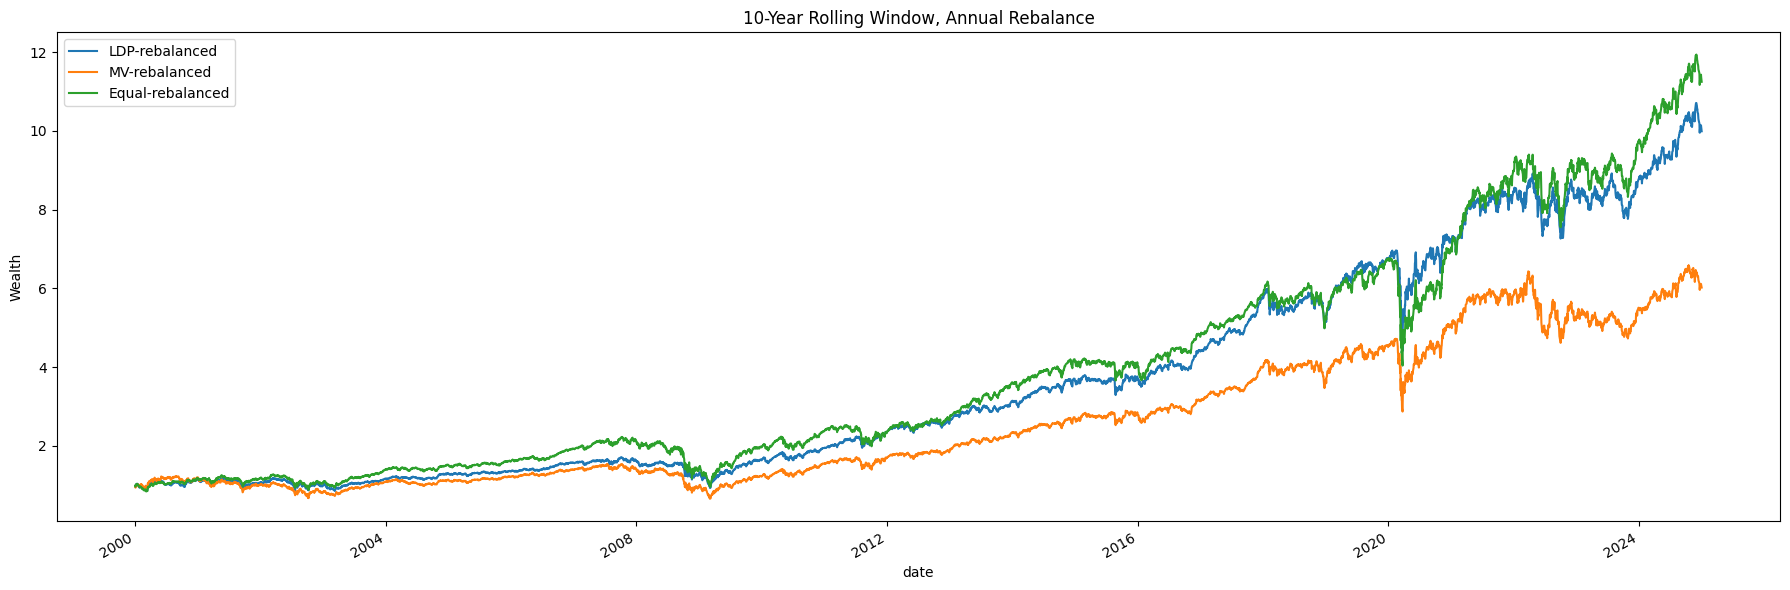


===== Performance Summary (11y rolling) =====
                  Ann_Return  Ann_Vol  Sharpe  Max_Drawdown  Turnover
LDP-rebalanced        0.0966   0.1814  0.5327       -0.4368    0.6104
MV-rebalanced         0.0840   0.2065  0.4069       -0.4782    0.6662
Equal-rebalanced      0.1026   0.1952  0.5254       -0.5692    0.1544


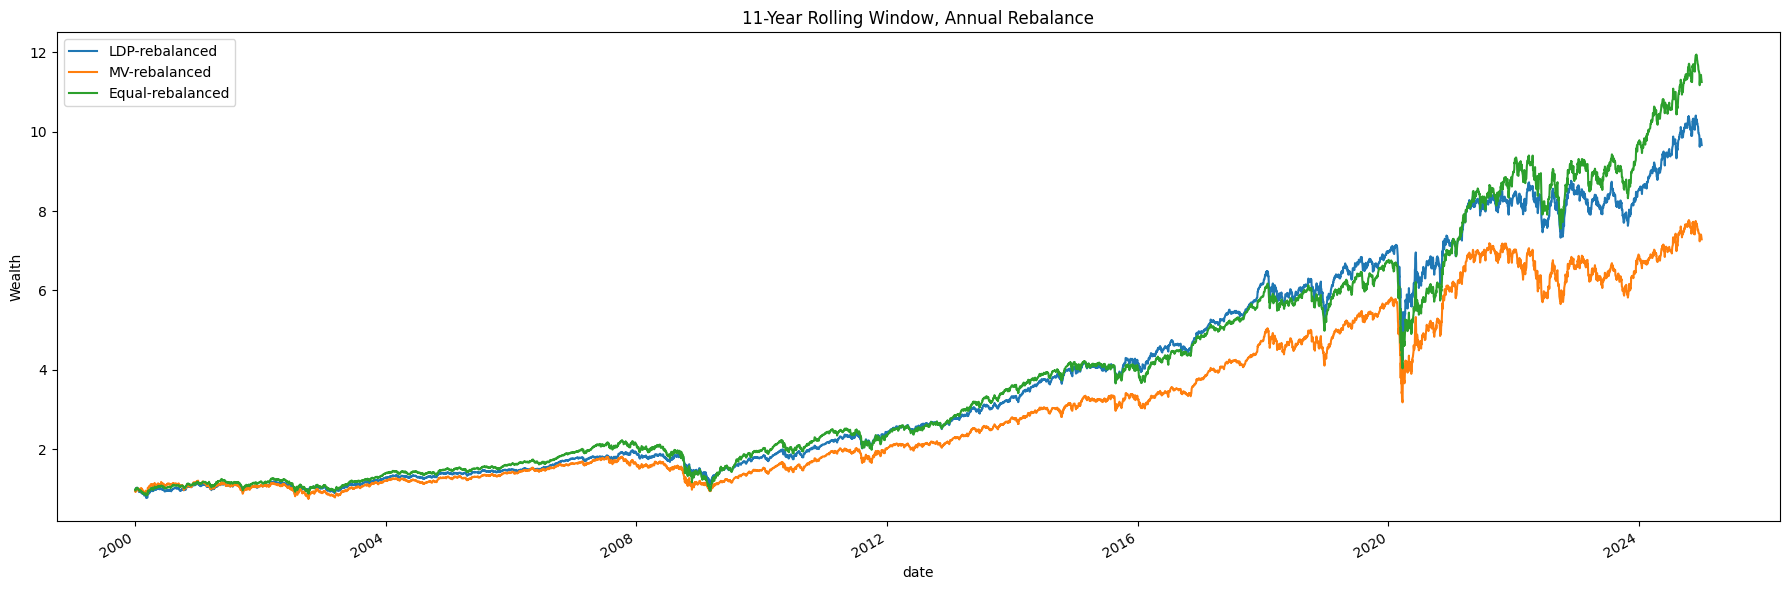


===== Performance Summary (12y rolling) =====
                  Ann_Return  Ann_Vol  Sharpe  Max_Drawdown  Turnover
LDP-rebalanced        0.0905   0.1804  0.5016       -0.4657    0.5995
MV-rebalanced         0.0918   0.2041  0.4496       -0.5518    0.6346
Equal-rebalanced      0.1026   0.1952  0.5254       -0.5692    0.1544


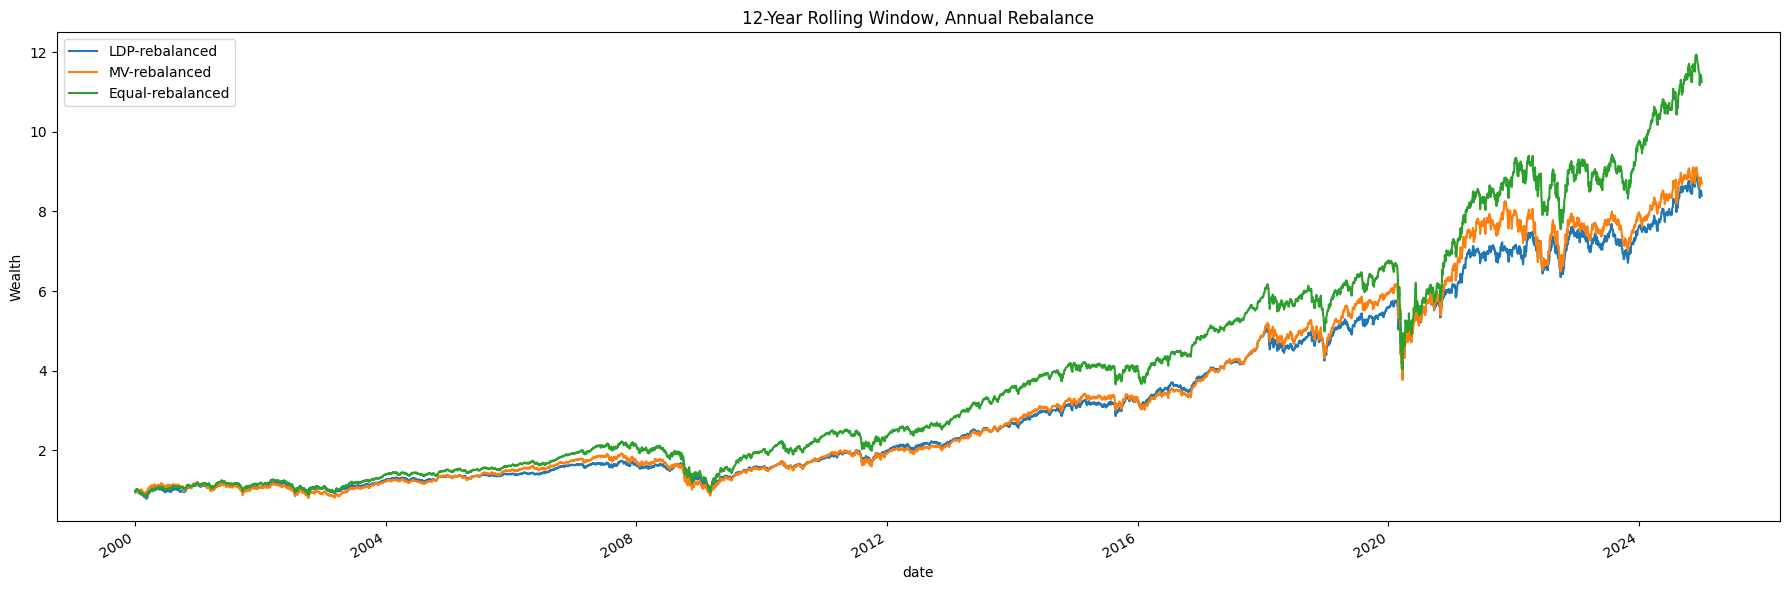


===== Performance Summary (13y rolling) =====
                  Ann_Return  Ann_Vol  Sharpe  Max_Drawdown  Turnover
LDP-rebalanced        0.0943   0.1811  0.5210       -0.4670    0.6067
MV-rebalanced         0.0869   0.2055  0.4227       -0.5581    0.6383
Equal-rebalanced      0.1026   0.1952  0.5254       -0.5692    0.1544


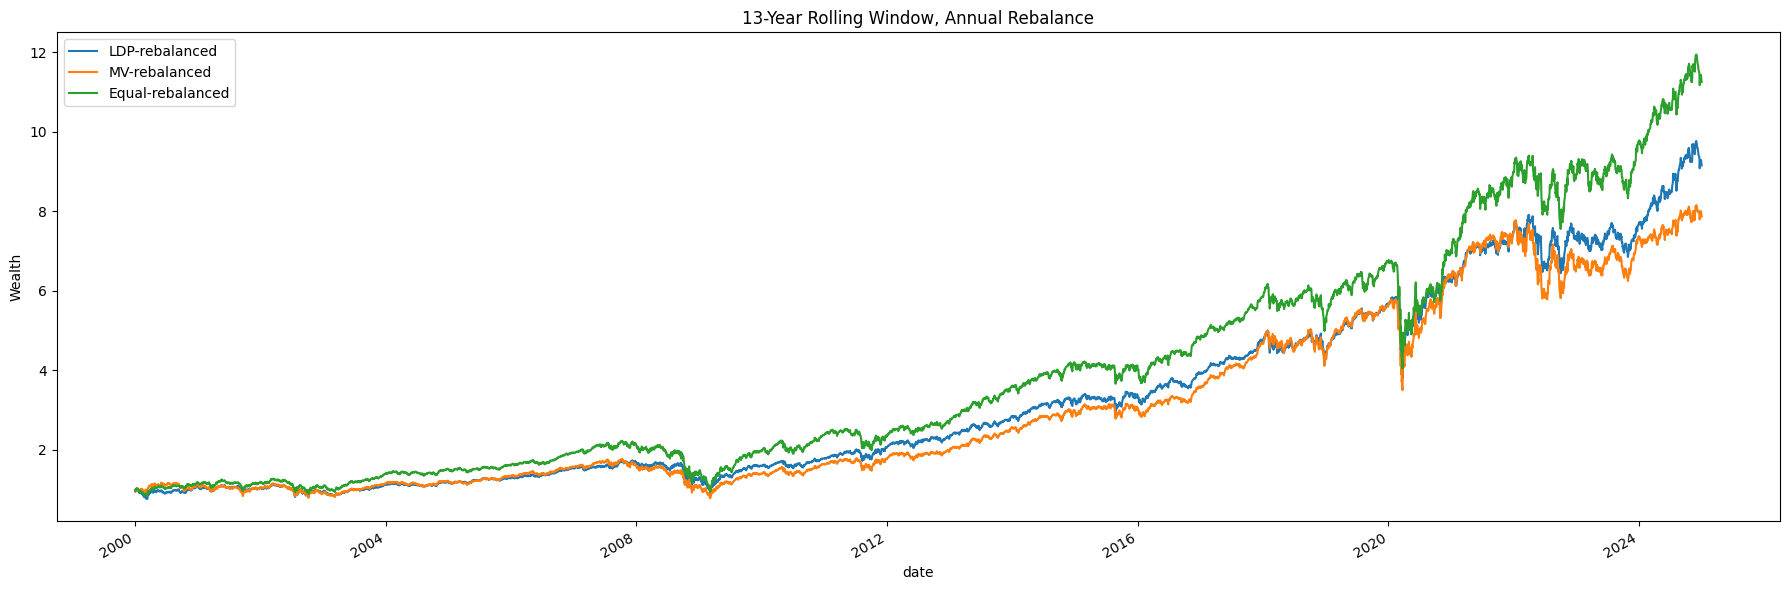


===== Performance Summary (14y rolling) =====
                  Ann_Return  Ann_Vol  Sharpe  Max_Drawdown  Turnover
LDP-rebalanced        0.1027   0.1794  0.5727       -0.4757    0.5896
MV-rebalanced         0.0940   0.2058  0.4567       -0.5666    0.5564
Equal-rebalanced      0.1026   0.1952  0.5254       -0.5692    0.1544


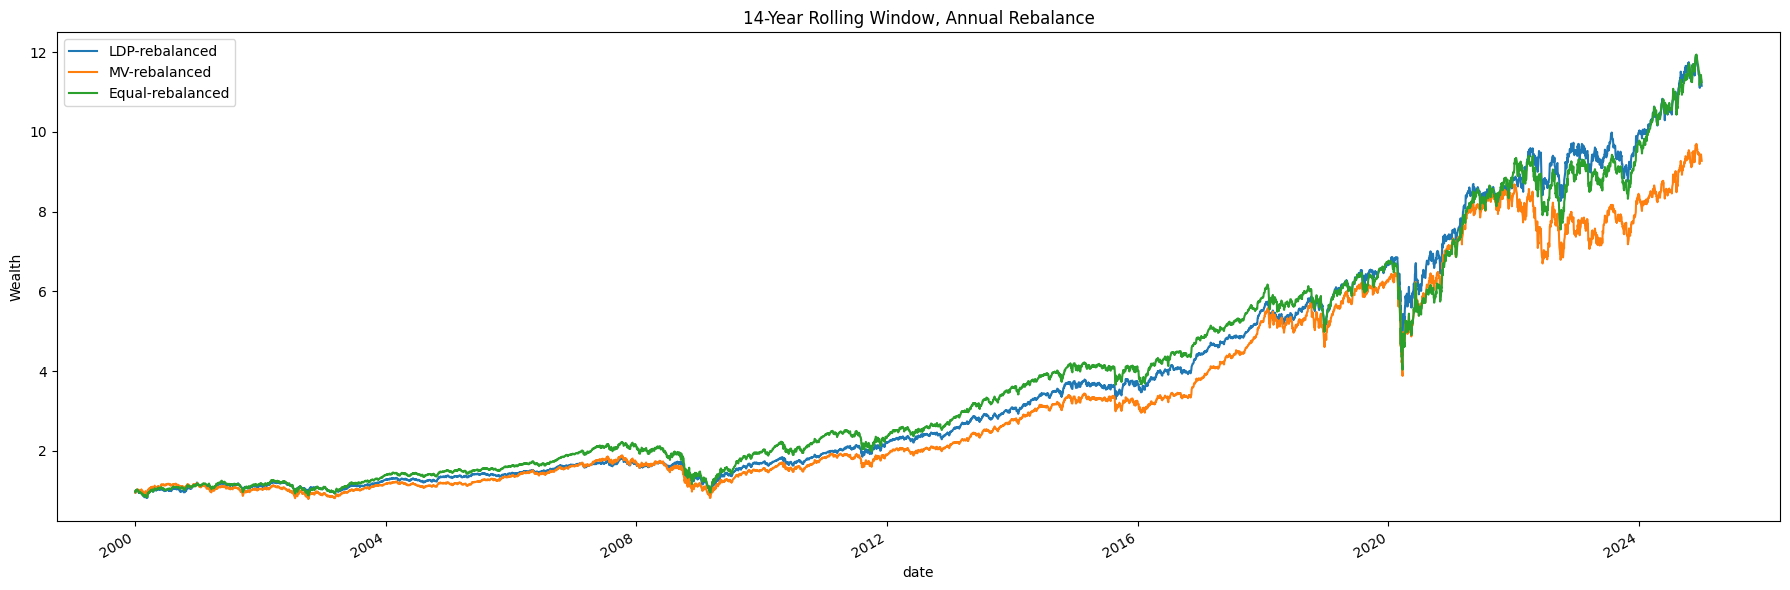


===== Performance Summary (15y rolling) =====
                  Ann_Return  Ann_Vol  Sharpe  Max_Drawdown  Turnover
LDP-rebalanced        0.1015   0.1790  0.5670       -0.4890    0.5603
MV-rebalanced         0.0873   0.2040  0.4281       -0.5866    0.5542
Equal-rebalanced      0.1026   0.1952  0.5254       -0.5692    0.1544


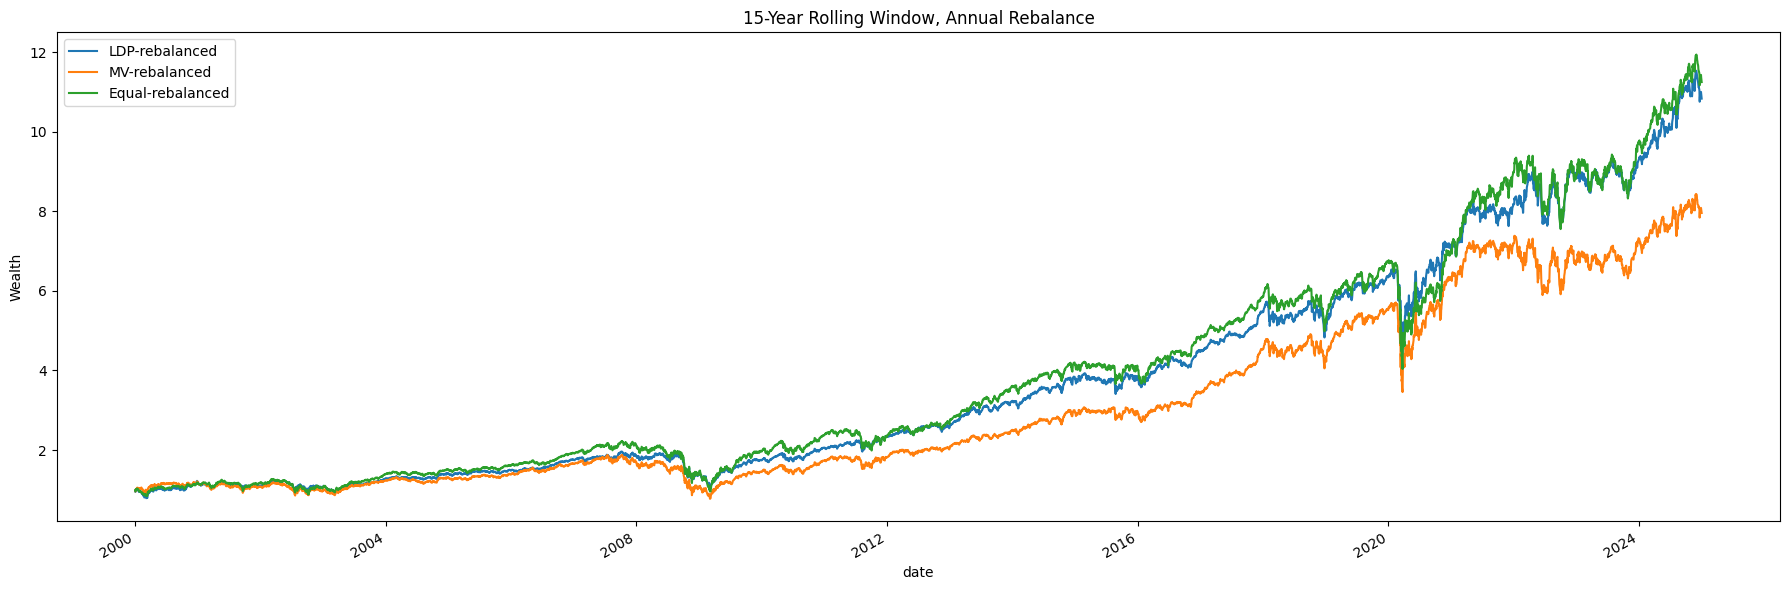


===== Performance Summary (16y rolling) =====
                  Ann_Return  Ann_Vol  Sharpe  Max_Drawdown  Turnover
LDP-rebalanced        0.1047   0.1807  0.5795       -0.5107    0.5760
MV-rebalanced         0.0894   0.2118  0.4219       -0.6265    0.5360
Equal-rebalanced      0.1026   0.1952  0.5254       -0.5692    0.1544


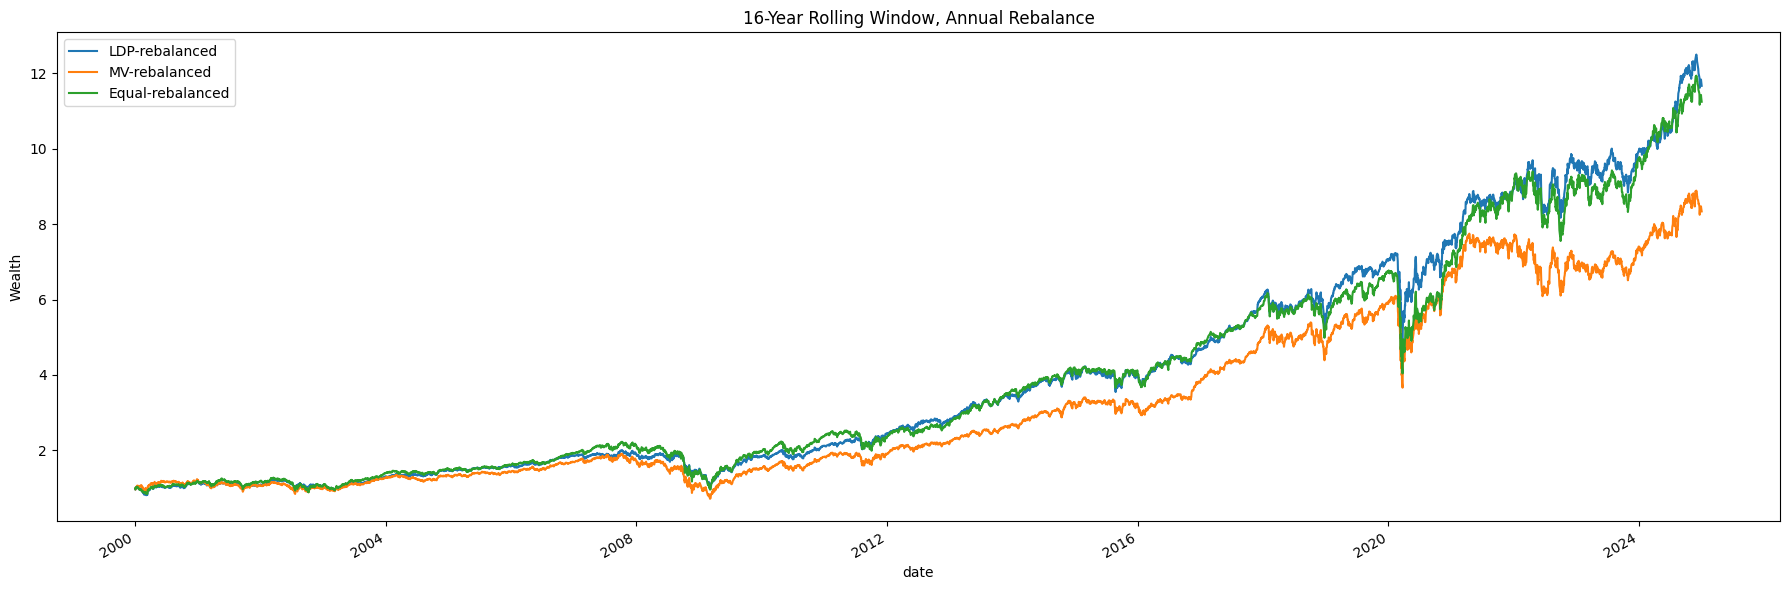


===== Performance Summary (17y rolling) =====
                  Ann_Return  Ann_Vol  Sharpe  Max_Drawdown  Turnover
LDP-rebalanced        0.1083   0.1766  0.6134       -0.5079    0.5484
MV-rebalanced         0.0889   0.2101  0.4233       -0.6312    0.5080
Equal-rebalanced      0.1026   0.1952  0.5254       -0.5692    0.1544


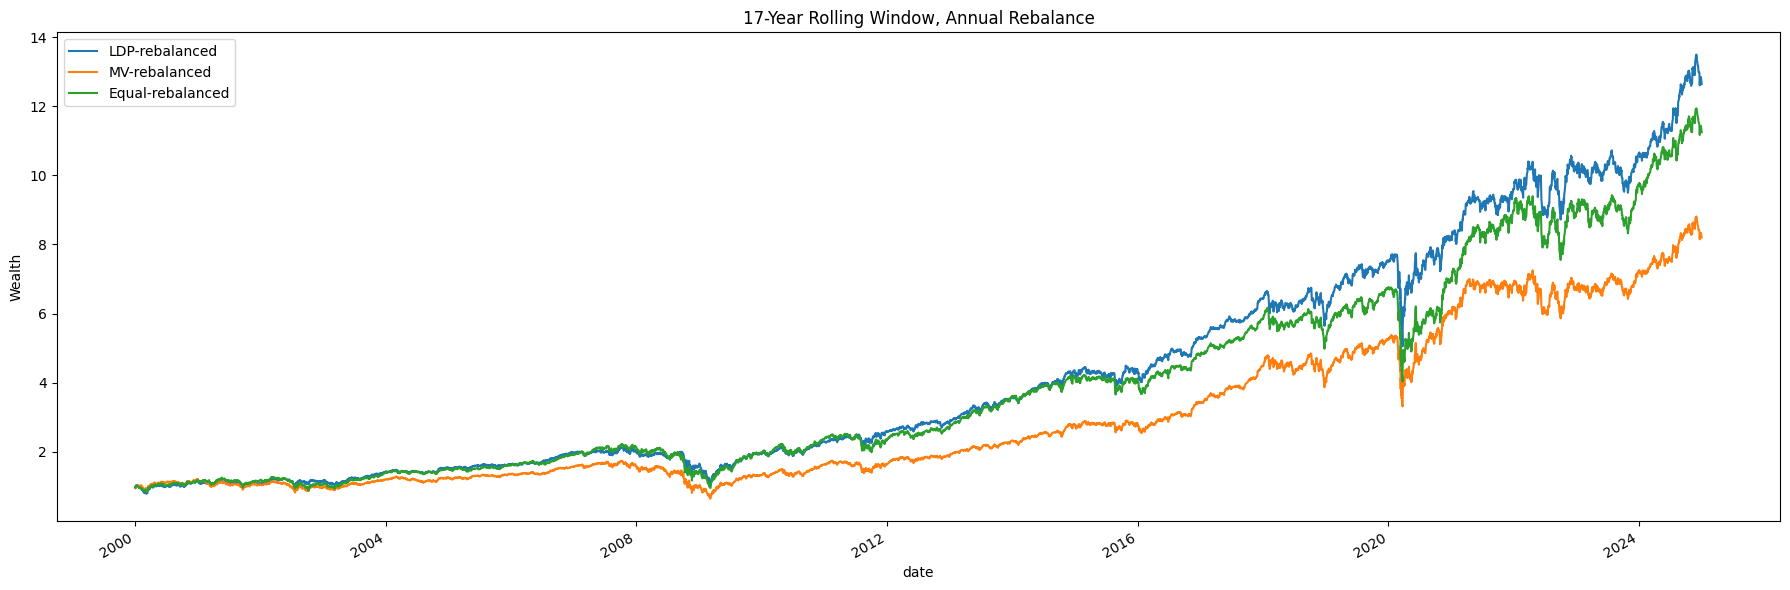


===== Performance Summary (18y rolling) =====
                  Ann_Return  Ann_Vol  Sharpe  Max_Drawdown  Turnover
LDP-rebalanced        0.1056   0.1780  0.5931       -0.4708    0.5145
MV-rebalanced         0.0799   0.2096  0.3813       -0.6168    0.5036
Equal-rebalanced      0.1026   0.1952  0.5254       -0.5692    0.1544


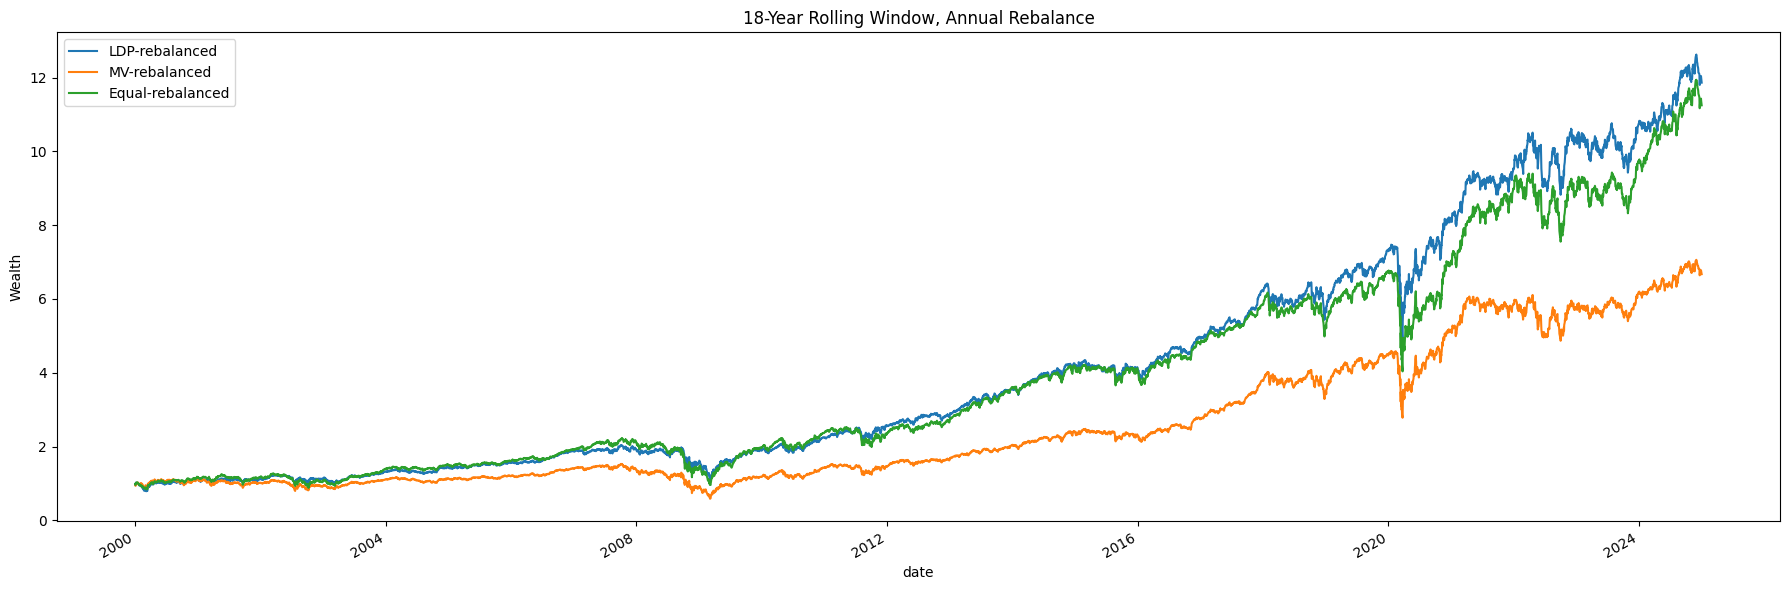


===== Performance Summary (19y rolling) =====
                  Ann_Return  Ann_Vol  Sharpe  Max_Drawdown  Turnover
LDP-rebalanced        0.1007   0.1779  0.5661       -0.4568    0.4934
MV-rebalanced         0.0656   0.2073  0.3164       -0.5838    0.5391
Equal-rebalanced      0.1026   0.1952  0.5254       -0.5692    0.1544


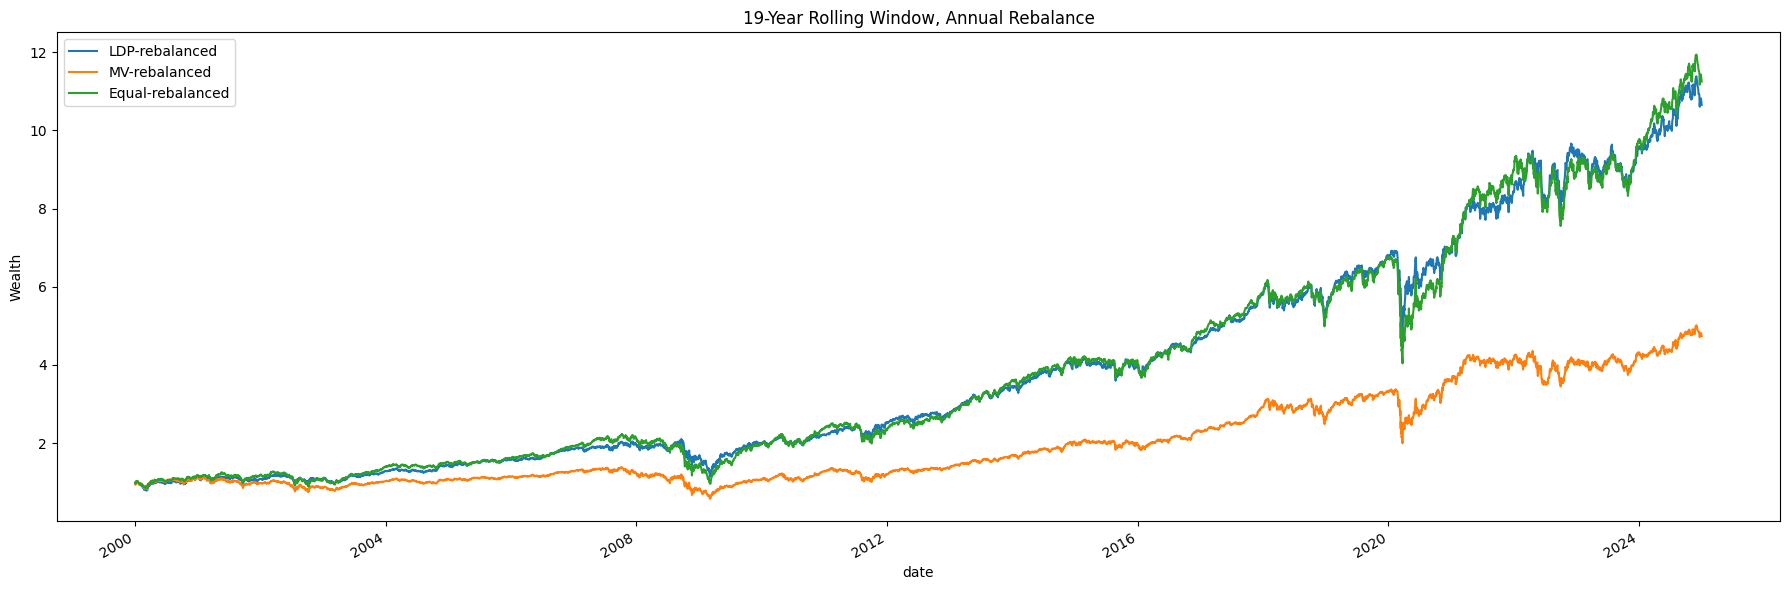


===== Performance Summary (20y rolling) =====
                  Ann_Return  Ann_Vol  Sharpe  Max_Drawdown  Turnover
LDP-rebalanced        0.1006   0.1802  0.5579       -0.4685    0.4562
MV-rebalanced         0.0685   0.2074  0.3301       -0.5681    0.4882
Equal-rebalanced      0.1026   0.1952  0.5254       -0.5692    0.1544


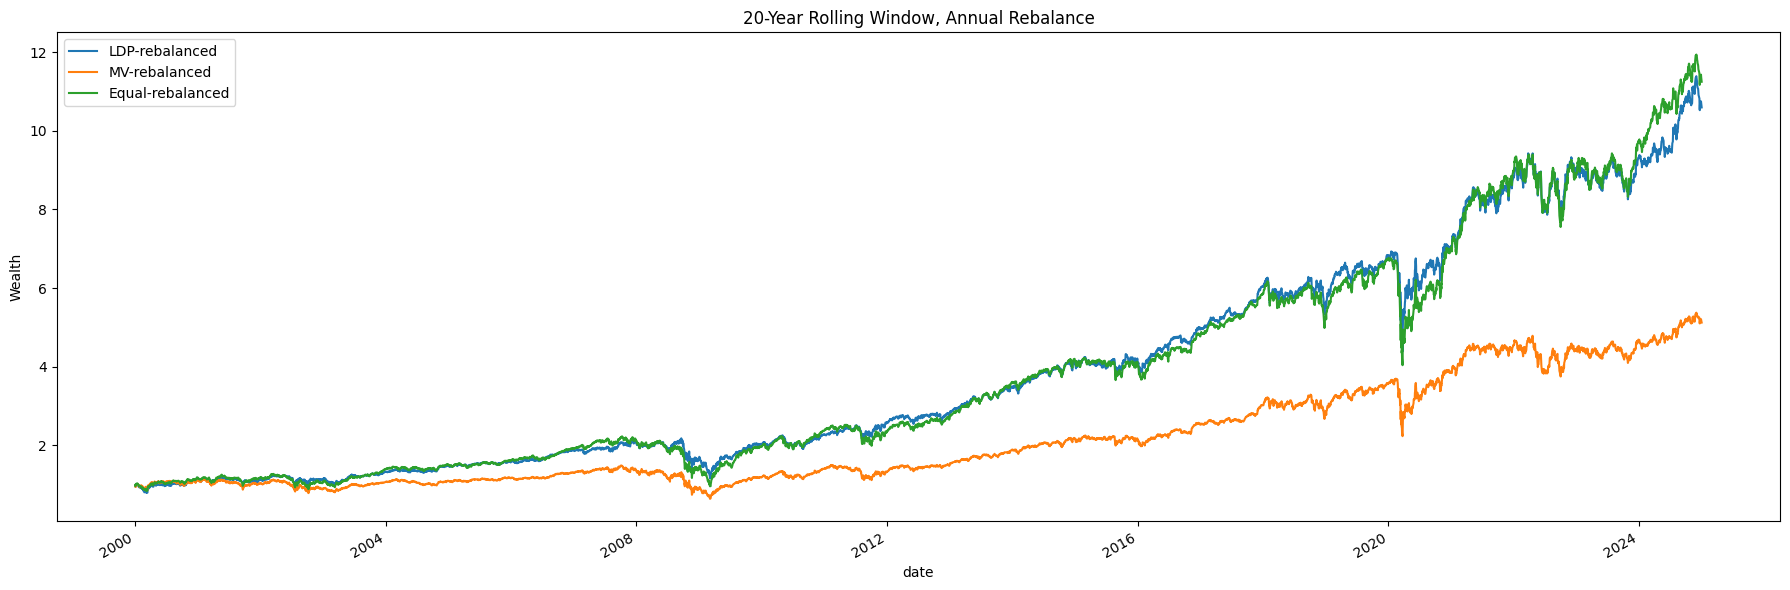

In [3]:
# ------------------------------- Global variable --------------------------------
C_TARGET       = np.log(1.5) / 252          # LDP target c
UB             = 0.10                       # weight upper bound
TRAIN_YEARS    = 20                         # rolling window
BACKTEST_START = "2000-01-01"               # start point of test data
# -----------------------------------------------------------------------

# ------------------------- 1. 日報酬資料 ---------------------------------
simple_return = df.pct_change().dropna()
simple_return.index = pd.to_datetime(simple_return.index)

train = simple_return.loc[:'1999-12-31']       # estimate μ、Σ
test  = simple_return.loc[BACKTEST_START:]     # backtest

tickers, n = list(df.columns), df.shape[1]

# ------------------------- 2. 取得權重函式 --------------------------------
def get_weights(ret: pd.DataFrame, method: str,
                c=C_TARGET, ub=UB) -> np.ndarray:
    """
    method ∈ {'mv', 'ldp', 'eq'}
    """
    n_   = ret.shape[1]
    mu   = ret.mean().values                
    Sigma = ret.cov().values

    if method == 'eq':
        return np.full(n_, 1/n_)

    if method == 'mv':
        w = cp.Variable(n_)

        objective_mv = cp.Maximize(w @ mu - 0.5*cp.quad_form(w, Sigma))
        constraints_mv = [
            cp.sum(w) == 1, 
            w >= 0, 
            w <= ub
        ]

        problem_mv = cp.Problem(
            objective_mv, 
            constraints_mv
        )
        problem_mv.solve()

        return w.value

    if method == 'ldp':
        v = np.linalg.inv(Sigma) @ mu
        d = mu @ v
        w_star = np.sqrt(2*c/d) * v         # closed form solution
        w_var  = cp.Variable(n_)
        cp.Problem(cp.Minimize(cp.sum_squares(w_var - w_star)),
                   [cp.sum(w_var) == 1, w_var >= 0, w_var <= ub]
        ).solve()

        return w_var.value


# ------------------------- 3. 投組 NAV 工具 ------------------------------
def apply_portfolio(ret_df, w, start_nav=1.0):
    """weighted cumulative NAV"""
    return pd.Series(start_nav * (1 + ret_df.values @ w).cumprod(), index=ret_df.index)

def max_drawdown(nav: pd.Series) -> float:
    peak = nav.cummax()
    return float((nav/peak - 1).min())

# ------------------------- 4. 年度重平衡迴圈 ------------------------------
years = sorted(test.index.year.unique())    # 2000, 2001, …

# (a) 初始權重（用 1999-12-31 前資料估計）
w_ldp_cur = get_weights(simple_return.loc[:'1999-12-31'], 'ldp')
w_mv_cur  = get_weights(simple_return.loc[:'1999-12-31'], 'mv')
w_eq_cur  = np.full(n, 1/n)

nav_ldp = nav_mv = nav_eq = 1.0
wealth_ldp, wealth_mv, wealth_eq = [], [], []
turn_ldp, turn_mv, turn_eq = [], [], []

results_lst = []

for TRAIN_YEARS in range(10, 21):          # 10,11,…,20
    # -------- (A) 重新初始化一切狀態 ----------------------------------
    nav_ldp = nav_mv = nav_eq = 1.0

    w_ldp_cur = get_weights(simple_return.loc[:'1999-12-31'], 'ldp')
    w_mv_cur  = get_weights(simple_return.loc[:'1999-12-31'], 'mv')
    w_eq_cur  = np.full(n, 1/n)

    wealth_ldp, wealth_mv, wealth_eq = [], [], []
    turn_ldp,  turn_mv,  turn_eq  = [], [], []

    # -------- (B) 年度回圈 -------------------------------------------
    for yr in years:
        yr_start = pd.Timestamp(f"{yr}-01-01")
        yr_end   = pd.Timestamp(f"{yr}-12-31")

        # (1) rolling 訓練集
        train_ret = simple_return.loc[
            yr_start - pd.DateOffset(years=TRAIN_YEARS):
            yr_start - pd.DateOffset(days=1)
        ]

        # (2) 新權重
        w_mv  = get_weights(train_ret, 'mv')
        w_ldp = get_weights(train_ret, 'ldp')
        w_eq  = get_weights(train_ret, 'eq')

        # (3) 當年 NAV
        yr_ret = test.loc[str(yr)]
        wealth_mv .append(apply_portfolio(yr_ret, w_mv , nav_mv ))
        wealth_ldp.append(apply_portfolio(yr_ret, w_ldp, nav_ldp))
        wealth_eq .append(apply_portfolio(yr_ret, w_eq , nav_eq ))

        # (4) turnover
        grow = (1 + yr_ret).prod().values
        w_mv_end  = (w_mv_cur  * grow) / (w_mv_cur  * grow).sum()
        w_ldp_end = (w_ldp_cur * grow) / (w_ldp_cur * grow).sum()
        w_eq_end  = (w_eq_cur  * grow) / (w_eq_cur  * grow).sum()

        turn_mv .append(np.abs(w_mv_end  - w_mv ).sum())
        turn_ldp.append(np.abs(w_ldp_end - w_ldp).sum())
        turn_eq .append(np.abs(w_eq_end  - w_eq ).sum())

        # (5) 更新狀態
        nav_mv , nav_ldp, nav_eq = (wealth_mv [-1].iloc[-1],
                                    wealth_ldp[-1].iloc[-1],
                                    wealth_eq [-1].iloc[-1])
        w_mv_cur, w_ldp_cur, w_eq_cur = w_mv, w_ldp, w_eq

    # -------- (C) 彙整 --------------------------------------
    wealth = pd.concat([
        pd.concat(wealth_ldp).rename("LDP-rebalanced"),
        pd.concat(wealth_mv ).rename("MV-rebalanced"),
        pd.concat(wealth_eq ).rename("Equal-rebalanced")
    ], axis=1)



    # -------- (D) 績效指標 ------------------------------------------
    def perf(nav, to):
        ret = nav.pct_change().dropna()
        ann_r = (1+ret).prod()**(252/len(ret)) - 1
        ann_v = ret.std()*np.sqrt(252)
        return {
            "Ann_Return":   ann_r,
            "Ann_Vol":      ann_v,
            "Sharpe":       ann_r/ann_v if ann_v>0 else np.nan,
            "Max_Drawdown": max_drawdown(nav),
            "Turnover":     np.mean(to)
        }

    summary = pd.DataFrame({
        "LDP-rebalanced"  : perf(wealth["LDP-rebalanced"],  turn_ldp),
        "MV-rebalanced"   : perf(wealth["MV-rebalanced"],   turn_mv ),
        "Equal-rebalanced": perf(wealth["Equal-rebalanced"],turn_eq)
    }).T.round(4)

    print(f"\n===== Performance Summary ({TRAIN_YEARS}y rolling) =====")
    print(summary)
    results_lst.append(summary)

    # --------- 畫圖 ----------------
    fig, ax = plt.subplots(figsize=(18, 6))
    wealth.plot(ax=ax)
    ax.set_title(f"{TRAIN_YEARS}-Year Rolling Window, Annual Rebalance")
    ax.set_ylabel("Wealth")
    ax.legend(); plt.tight_layout(); plt.show(); plt.close(fig)